<a href="https://colab.research.google.com/github/carlosheadst/Identificacao-Glaucoma-Origa/blob/main/Unet_Origa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Conectar com drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [28]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [3]:
# Carregar o arquivo CSV
origa_list = pd.read_csv('/content/drive/MyDrive/ORIGA/OrigaList.csv')

In [4]:
origa_list.head()

,Eye,Filename,ExpCDR,Set,Glaucoma
0,OD,001.jpg,0.7097,A,0
1,OS,002.jpg,0.6953,A,0
2,OS,003.jpg,0.9629,A,0
3,OD,004.jpg,0.7246,A,0
4,OS,005.jpg,0.6138,A,0


In [12]:
# Dividir o conjunto de dados em treinamento e validação (80% treinamento, 20% validação)
train_df, val_df = train_test_split(origa_list, test_size=0.2, random_state=42, stratify=origa_list['Glaucoma'])

In [13]:
# Função para carregar e pré-processar as imagens e máscaras
def load_and_preprocess_images(df, img_path, mask_path):
    img_list = []
    mask_list = []

    for _, row in df.iterrows():
        # Carregar a imagem e a máscara
        img = Image.open(os.path.join(img_path, row["Filename"]))
        mask_filename = os.path.splitext(row["Filename"])[0] + ".png"  # Converter a extensão do arquivo para .png
        mask = Image.open(os.path.join(mask_path, mask_filename))

        # Redimensionar as imagens e máscaras para as dimensões desejadas (128x128, por exemplo)
        img = img.resize((128, 128))
        mask = mask.resize((128, 128))

        # Converter as imagens e máscaras para arrays numpy e normalizar os valores
        img_array = np.array(img) / 255.0
        mask_array = np.array(mask) / 255.0

        img_list.append(img_array)
        mask_list.append(mask_array)

    return np.array(img_list), np.array(mask_list)

In [14]:
# Caminho dos arquivos
path_images = '/content/drive/MyDrive/ORIGA/Images'
path_masks = '/content/drive/MyDrive/ORIGA/Masks'

In [15]:
# Carregar e pré-processar as imagens e máscaras de treinamento e validação
train_imgs, train_masks = load_and_preprocess_images(train_df, path_images, path_masks)
val_imgs, val_masks = load_and_preprocess_images(val_df, path_images, path_masks)

## Definindo arquitetura U-NET

In [17]:
def build_unet(input_shape):
    inputs = layers.Input(input_shape)

    # Contração (encoder)
    c1 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(p4)
    c5 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(c5)

    # Expansão (decoder)
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u8)
    c8 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding="same")(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(u9)
    c9 = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(c9)

    # Camada de saída
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model

In [18]:
# Parâmetros do modelo
input_shape = (128, 128, 3)

# Construir e compilar o modelo U-Net
unet = build_unet(input_shape)
unet.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [19]:
# Treinar o modelo U-Net
history = unet.fit(train_imgs, train_masks, validation_data=(val_imgs, val_masks), epochs=50, batch_size=32)

Epoch 1/50
17/17 [==============================] - 38s 672ms/step - loss: 0.1932 - accuracy: 0.9227 - val_loss: 0.0016 - val_accuracy: 0.9803
Epoch 2/50
17/17 [==============================] - 2s 144ms/step - loss: 0.0016 - accuracy: 0.9803 - val_loss: 0.0016 - val_accuracy: 0.9803
Epoch 3/50
17/17 [==============================] - 3s 202ms/step - loss: 0.0016 - accuracy: 0.9803 - val_loss: 0.0016 - val_accuracy: 0.9803
Epoch 4/50
17/17 [==============================] - 3s 152ms/step - loss: 0.0016 - accuracy: 0.9803 - val_loss: 0.0016 - val_accuracy: 0.9803
Epoch 5/50
17/17 [==============================] - 3s 211ms/step - loss: 0.0016 - accuracy: 0.9803 - val_loss: 0.0016 - val_accuracy: 0.9803
Epoch 6/50
17/17 [==============================] - 4s 213ms/step - loss: 0.0016 - accuracy: 0.9803 - val_loss: 0.0016 - val_accuracy: 0.9803
Epoch 7/50
17/17 [==============================] - 3s 204ms/step - loss: 0.0016 - accuracy: 0.9803 - val_loss: 0.0016 - val_accuracy: 0.9803
Epoch

In [20]:
# Salvar o modelo treinado
unet.save("glaucoma_unet.h5")

## Plots


In [29]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot da loss de treinamento e validação
    ax1.plot(history.history['loss'], label='Train')
    ax1.plot(history.history['val_loss'], label='Validation')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot da acurácia de treinamento e validação
    ax2.plot(history.history['accuracy'], label='Train')
    ax2.plot(history.history['val_accuracy'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

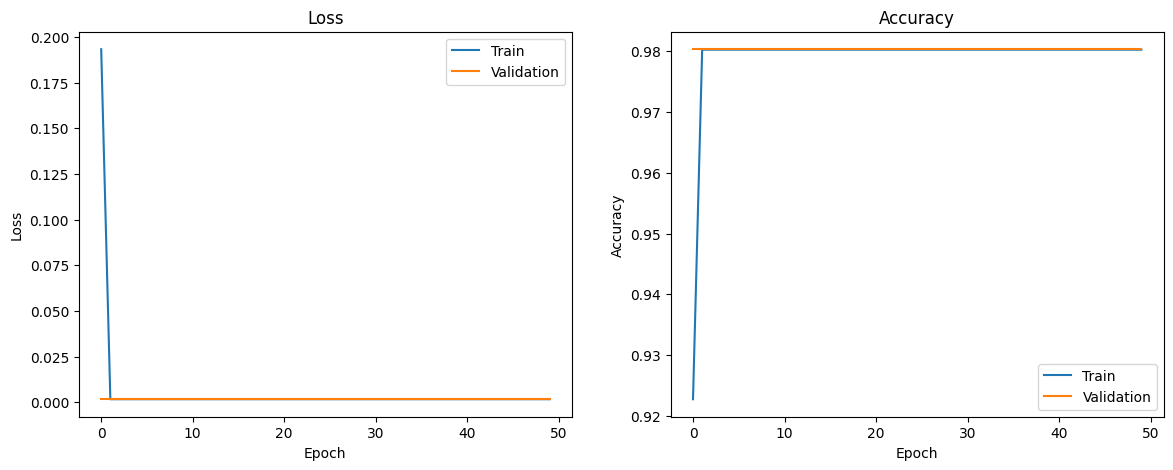

In [30]:
plot_training_history(history)

## Medindo acurácia

### Padrão

In [21]:
# Avaliar o modelo no conjunto de validação
loss, accuracy = unet.evaluate(val_imgs, val_masks)

print(f"Acurácia no conjunto de validação: {accuracy * 100:.2f}%")

5/5 [==============================] - 1s 204ms/step - loss: 0.0016 - accuracy: 0.9803
Acurácia no conjunto de validação: 98.03%


### IoU - Intersection over Union

In [24]:
def calculate_iou(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

    epsilon = 1e-6  # Adiciona um pequeno valor para evitar divisão por zero
    iou = intersection / (union + epsilon)
    return iou

def evaluate_iou(model, val_imgs, val_masks):
    iou_values = []
    
    for img, true_mask in zip(val_imgs, val_masks):
        img = np.expand_dims(img, axis=0)
        pred_mask = model.predict(img)
        
        iou = calculate_iou(true_mask, pred_mask[0])
        iou_values.append(iou)

    mean_iou = np.mean(iou_values)
    return mean_iou

In [25]:
mean_iou = evaluate_iou(unet, val_imgs, val_masks)
print(f"Média da IoU no conjunto de validação: {mean_iou:.4f}")

1/1 [==============================] - 0s 19ms/step
Média da IoU no conjunto de validação: 0.0000


### Dice

In [26]:
def calculate_dice(y_true, y_pred):
    y_true = tf.cast(y_true > 0.5, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    sum_true_pred = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

    epsilon = 1e-6  # Adiciona um pequeno valor para evitar divisão por zero
    dice = 2 * intersection / (sum_true_pred + epsilon)
    return dice

def evaluate_dice(model, val_imgs, val_masks):
    dice_values = []
    
    for img, true_mask in zip(val_imgs, val_masks):
        img = np.expand_dims(img, axis=0)
        pred_mask = model.predict(img)
        
        dice = calculate_dice(true_mask, pred_mask[0])
        dice_values.append(dice)

    mean_dice = np.mean(dice_values)
    return mean_dice

In [27]:
mean_dice = evaluate_dice(unet, val_imgs, val_masks)
print(f"Média da métrica Dice no conjunto de validação: {mean_dice:.4f}")

1/1 [==============================] - 0s 19ms/step
Média da métrica Dice no conjunto de validação: 0.0000
